# definition of example game
##  
### The agent's goal is go foward without any drive accidents
### But some obstacles are randomly generated in front of agent
### The agent can move left, move right or stay
### We are going to visualizing this game

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [25]:
environments = np.ones([16, 16])
environments[[0, -1]] = 0
environments[:, [0, -1]] = 0

In [26]:
agent = np.ones([4,3])
agent[:,1] = 0
agent[[1,3],:] = 0

In [27]:
def initializer(environments):
    agent_location = int(environments.shape[1]/2)
    bound = [2, environments.shape[1]-2]
    new_obstackle = np.random.randint(bound[0], bound[1], 1)
    return agent_location, [[1, new_obstackle[0]]]

In [232]:
def locate_agent(environments, location, agent):
    agent_h, agent_w = agent.shape
    length = environments.shape[0]-4
    possible_location = np.arange(length)+2
    result = environments*1
#`    assert location in possible_location, 'location is not proper'
    result[-(1+agent_h):-1,(location-int(agent_w/2)):(location+int(agent_w/2)+1)] -= (1-agent)
    return result

In [233]:
def obstackle_genertor(environments, post_obstackle_list, prob = 0.5):
    n = len(post_obstackle_list)
    num = 1
    bound = [2, environments.shape[1]-2]
    for i in range(n):
        num += 1/post_obstackle_list[i][0]
    number_obstackle = np.sum(np.random.binomial(1, prob/num))
    new_obstackle = np.random.randint(bound[0], bound[1], number_obstackle)
    return new_obstackle

In [234]:
def locate_obstackle(environments_with_agent, post_obstackle_list, new_obstackle = []):
    assert type(post_obstackle_list)==list, 'post obstackle is must be a list'
    agent_h, agent_w = agent.shape
    length = environments.shape[0]-4
    max_height = environments.shape[1]-3
    possible_location = np.arange(length)+2
    result = environments_with_agent*1
    n = len(post_obstackle_list)
    next_obstackle = []
    for i in range(n):
        location = post_obstackle_list[i]
        assert location[1] in possible_location, 'location is not proper'
        next_loc = location + np.array([1, 0])
        result[next_loc[0], (next_loc[1]-1):(next_loc[1]+2)] -= 1
        if next_loc[0]<=max_height:
            next_obstackle.append(next_loc)
    n = len(new_obstackle)
    for i in range(n):
        location = new_obstackle[i]
        assert location in possible_location, 'location is not proper'
        next_loc = np.array([1, location])
        result[1, (next_loc[1]-1):(next_loc[1]+2)] -= 1
        next_obstackle.append(next_loc)
    return result, next_obstackle

In [235]:
def judgment(environments_with_agent_and_obstackle):
    if -1 in environments_with_agent_and_obstackle:
        return 0
    else:
        return 1

In [236]:
def agent_action(current_location, move='stay'):
    next_location = current_location*1
    if move=='left':
        next_location -= 1
    if move=='right':
        next_location += 1
    return next_location

In [237]:
def play(environments, agent, agent_location, current_obstackle, prob = 0.5, move = 'stay', show = True):
    next_agent_location = agent_action(agent_location, move)
    state = locate_agent(environments, next_agent_location, agent)
    new_obstackle = obstackle_genertor(environments, current_obstackle, prob)
    new_env, next_obstackle = locate_obstackle(state, current_obstackle, new_obstackle)
    surv = judgment(new_env)
    plt.gray()
    if show==True:
        plt.imshow(new_env)
        plt.axis('off')
        plt.show()
    return next_agent_location, next_obstackle, surv, new_env

In [238]:
possible_move = ['left','right','stay']

0


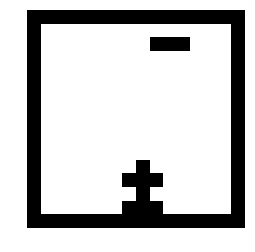

1


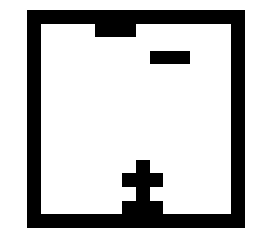

2


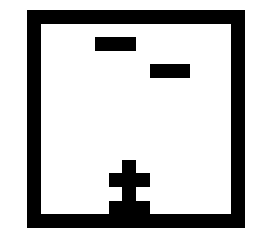

3


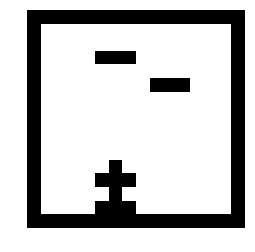

4


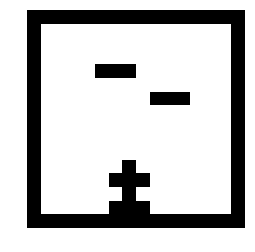

5


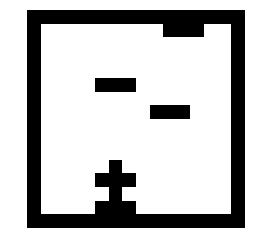

6


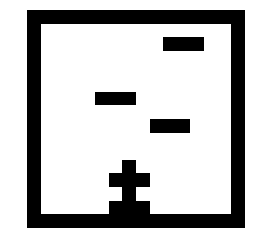

7


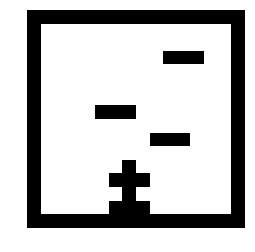

8


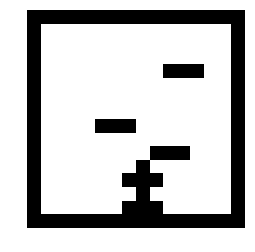

9


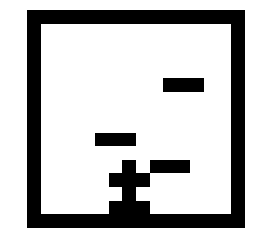

10


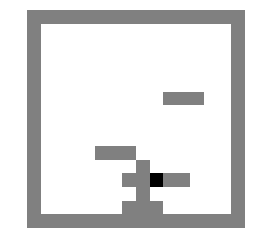

game over


In [239]:
for i in range(100):
    print(i)
    ranmove = possible_move[np.random.randint(0,3,1)[0]]
    if i==0:
        agent_location, current_obstackle = initializer(environments)
    agent_location, current_obstackle, surv, new_env = play(environments, agent, agent_location, current_obstackle, prob = 0.3, move = ranmove)
    if surv==0:
        print('game over')
        break

In [240]:
height, width = environments.shape

In [421]:
graph = tf.Graph()
with graph.as_default():
    state = tf.placeholder(tf.float32, [None, height, width, 1])
    n_state = tf.placeholder(tf.float32, [None, height, width, 1])
    act = tf.placeholder(tf.float32, [None, 3])
    reward = tf.placeholder(tf.float32, [None])
    lr = tf.placeholder(tf.float32, [])
    delta = tf.placeholder(tf.float32, [])
    
    w1 = tf.Variable(tf.random_normal([4, 4, 1, 128], stddev = 0.1))
    w2 = tf.Variable(tf.random_normal([4, 4, 128, 256], stddev = 0.1))
    w3 = tf.Variable(tf.random_normal([4*4*256, 1024], stddev = 0.1))
    b3 = tf.Variable(tf.zeros([1024]))
    w4 = tf.Variable(tf.random_normal([1024, 128], stddev = 0.1))
    b4 = tf.Variable(tf.zeros([128]))
    w5 = tf.Variable(tf.random_normal([128, 3], stddev = 0.1))
    b5 = tf.Variable(tf.zeros([3]))
    
    tw1 = tf.placeholder(tf.float32, [4, 4, 1, 128])
    tw2 = tf.placeholder(tf.float32, [4, 4, 128, 256])
    tw3 = tf.placeholder(tf.float32, [4*4*256, 1024])
    tb3 = tf.placeholder(tf.float32, [1024])
    tw4 = tf.placeholder(tf.float32, [1024, 128])
    tb4 = tf.placeholder(tf.float32, [128])
    tw5 = tf.placeholder(tf.float32, [128, 3])
    tb5 = tf.placeholder(tf.float32, [3])
    
    def network(_s):
        h1 = tf.nn.leaky_relu(tf.nn.conv2d(_s, w1, strides = [1,2,2,1], padding = 'SAME'))
        h2_1 = tf.nn.leaky_relu(tf.nn.conv2d(h1, w2, strides = [1,2,2,1], padding = 'SAME'))
        h2_2 = tf.reshape(h2_1, [-1, 4*4*256])
        
        h3 = tf.nn.leaky_relu(tf.add(tf.matmul(h2_2, w3), b3))
        h4 = tf.nn.leaky_relu(tf.add(tf.matmul(h3, w4), b4))
        out = tf.add(tf.matmul(h4, w5), b5)
        return out
    
    def tnetwork(_s):
        h1 = tf.nn.leaky_relu(tf.nn.conv2d(_s, tw1, strides = [1,2,2,1], padding = 'SAME'))
        h2_1 = tf.nn.leaky_relu(tf.nn.conv2d(h1, tw2, strides = [1,2,2,1], padding = 'SAME'))
        h2_2 = tf.reshape(h2_1, [-1, 4*4*256])
        
        h3 = tf.nn.leaky_relu(tf.add(tf.matmul(h2_2, tw3), tb3))
        h4 = tf.nn.leaky_relu(tf.add(tf.matmul(h3, tw4), tb4))
        out = tf.reduce_max(tf.add(tf.matmul(h4, tw5), tb5), 1)
        return out
    
    Qt0 = network(state)
    Qt1 = tnetwork(n_state)
    td_target = tf.reshape(reward + delta*Qt1, [-1, 1])
    obj = tf.reduce_mean((Qt0*act-td_target)**2)
    train_step = tf.train.AdamOptimizer(lr).minimize(obj)
    
    sess = tf.Session()
    init = tf.global_variables_initializer()

In [422]:
def arg_act(_state):
    n = _state.shape[0]
    result = np.zeros([n, 3])
    Q = sess.run(Qt0, feed_dict = {state:_state})
    result[:, np.argmax(Q, 1)] = 1
    return result

In [423]:
def act_to_string(_act):
    n = _act.shape[0]
    dex = np.array(['left', 'right', 'stay'])
    return dex[np.argmax(_act, 1)]

In [424]:
def epsilon_greedy(_state, epsilon):
    n = _state.shape[0]
    Q = sess.run(Qt0, feed_dict = {state:_state})
    prob = np.zeros([n, 3])
    result = np.zeros([n, 3])
    prob[np.arange(n),np.argmax(Q, 1)] = 1
    prob_mat = prob*(1-epsilon+epsilon/3)+(1-prob)*epsilon/3
    for i in range(n):
        result[i] = np.random.multinomial(n = 1, pvals = prob_mat[i])
    return result

In [482]:
max_epoch = 10000
mbs = 1
memory_size = 100

In [497]:
sess.run(init)

In [498]:
for epoch in range(max_epoch):
    if epoch%memory_size==0:
        Tw1 = w1.eval(sess)
        Tw2 = w2.eval(sess)
        Tw3 = w3.eval(sess)
        Tb3 = b3.eval(sess)
        Tw4 = w4.eval(sess)
        Tb4 = b4.eval(sess)
        Tw5 = w5.eval(sess)
        Tb5 = b5.eval(sess)
    surv = 1
    r = 0
    history_state = np.zeros([0, 16, 16, 1])
    history_act = np.zeros([0, 3])
    history_reward = np.zeros([0])
    agent_location, current_obstackle = initializer(environments)
    agent_location, current_obstackle, surv, new_env = play(environments, agent, agent_location, current_obstackle, 
                                                            prob = 0.6, move = ranmove, show=False)
    history_state = np.concatenate((history_state, new_env.reshape([1,16,16,1])), 0)

    while surv==1:
        moves = epsilon_greedy(new_env.reshape([1,16,16,1]), epsilon = 0.1)
        agent_location, current_obstackle, surv, new_env = play(environments, agent, agent_location, current_obstackle,
                                                                prob = 0.7, move = act_to_string(moves), show=False)
        if surv==0:
            r = -1
        history_state = np.concatenate((history_state, new_env.reshape([1,16,16,1])), 0)
        history_act = np.concatenate((history_act, moves.reshape([1,3])), 0)
        history_reward = np.concatenate((history_reward, np.array(r).reshape([-1])))

        if surv==0:
            break
        
    learning_iter = len(history_state)-mbs
    if learning_iter>=1:
        for j in range(learning_iter-1):
            _, l = sess.run([train_step, obj], feed_dict = {state:history_state[j:(j+mbs)], n_state:history_state[(j+1):(j+1+mbs)], 
                                                            act:history_act[j:(j+mbs)], reward:history_reward[(j+1):(j+1+mbs)], delta:0.9, lr:1e-4, 
                                                            tw1:Tw1, tw2:Tw2, tw3:Tw3, tb3:Tb3, tw4:Tw4, tb4:Tb4, tw5:Tw5, tb5:Tb5})
    if (epoch+1)%500==0:
        print(l, len(history_state))

5.23294 10
0.140908 11
0.0650799 11
0.117902 12
1.38277 10
1.6655 19
2.6485 14
0.0410577 10
1.74836 11
0.0138043 10
2.62452 10
0.200263 11
0.134878 15
0.232192 11
0.289816 16
0.481098 11
0.296302 15
0.27249 11
0.904147 10
0.172274 10
0.841318 43
0.0128348 13
1.94843 10
0.246178 13
2.04885 23
0.808337 11
2.32864 11
1.73765 19
1.14364 24
1.72679 16
0.603246 12
1.72069 10
2.48074 12
0.938454 22
2.54353 17
4.32185 32
2.28544 33
0.651907 12
2.35976 11
1.52827 11
2.70098 16
3.33921 13
1.85834 26
1.61468 18
1.6399 27
3.39016 32
4.6082 15
2.23026 20
2.22438 19
3.30362 14
3.52327 17
8.49645 84
1.51707 13
3.69936 14
1.17263 21
2.99291 16
3.97831 18
2.19741 17
2.14318 22
5.93409 14
4.98636 11
2.71725 15
5.06168 27
4.30481 10
4.16778 25
1.87385 28
1.60299 16
2.96195 17
4.55352 37
2.94756 11
1.98803 12
4.60347 11
2.18435 22
2.61358 13
1.66165 36
2.15073 15
3.14795 24
2.67 11
2.97962 14
4.48805 14
4.15096 21
5.83239 15
2.83364 15
3.8991 67
5.69016 18
5.36385 39
1.343 15
3.00002 18
3.03149 12
1.99322

KeyboardInterrupt: 

In [515]:
history_state = np.zeros([0, 16, 16, 1])
history_act = np.zeros([0, 3])
history_reward = np.zeros([0])
agent_location, current_obstackle = initializer(environments)
agent_location, current_obstackle, surv, new_env = play(environments, agent, agent_location, current_obstackle, 
                                                        prob = 0.3, move = ranmove, show=False)
history_state = np.concatenate((history_state, new_env.reshape([1,16,16,1])), 0)

while surv==1:
    moves = epsilon_greedy(new_env.reshape([1,16,16,1]), epsilon = 0)
    agent_location, current_obstackle, surv, new_env = play(environments, agent, agent_location, current_obstackle,
                                                            prob = 0.3, move = act_to_string(moves), show=False)
    if surv==0:
        r = -1
    history_state = np.concatenate((history_state, new_env.reshape([1,16,16,1])), 0)
    history_act = np.concatenate((history_act, moves.reshape([1,3])), 0)
    history_reward = np.concatenate((history_reward, np.array(r).reshape([-1])))

    if surv==0:
        break

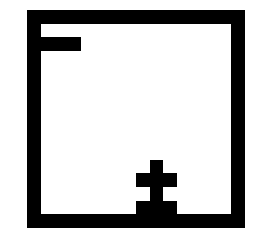

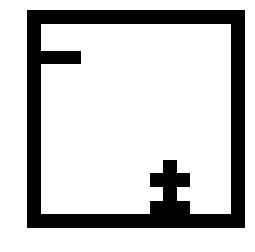

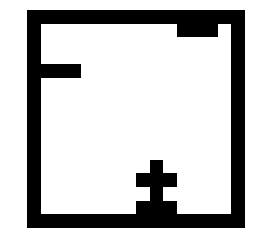

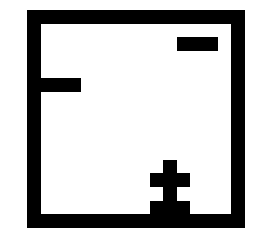

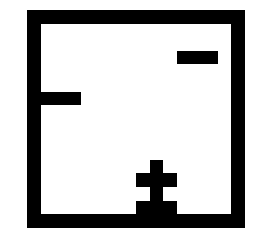

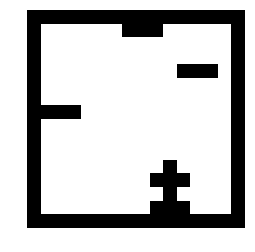

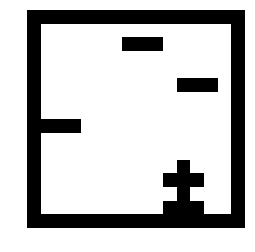

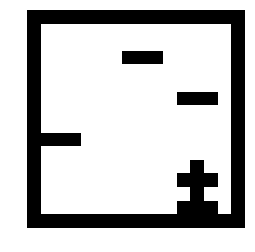

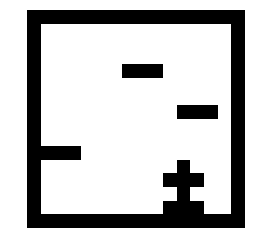

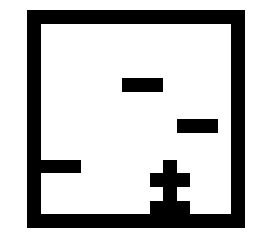

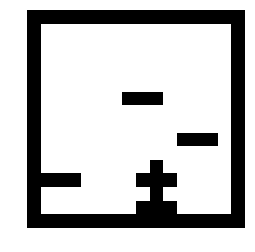

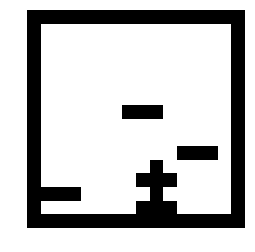

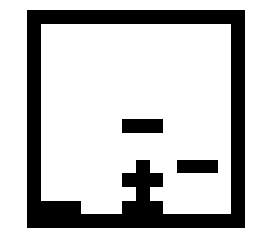

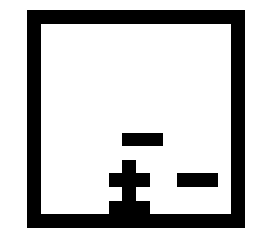

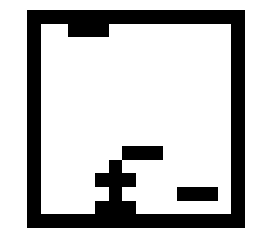

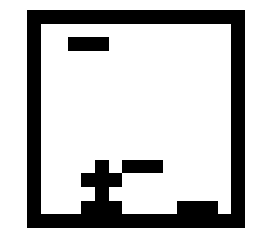

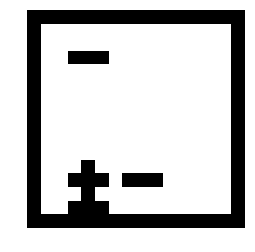

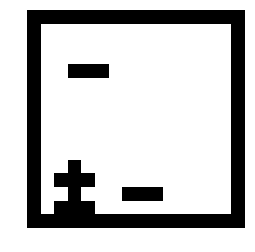

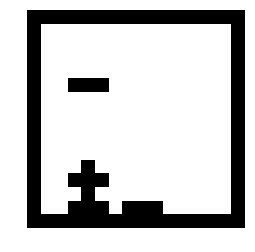

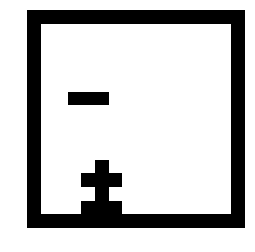

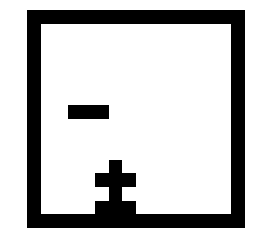

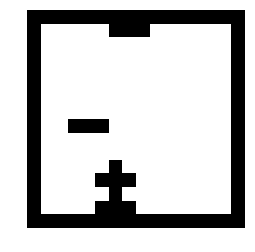

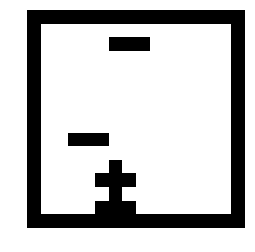

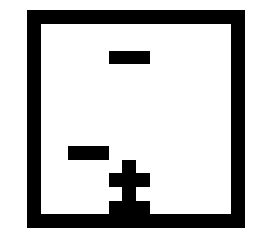

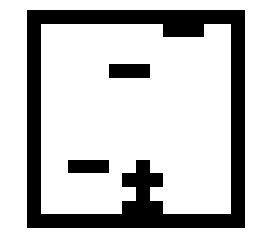

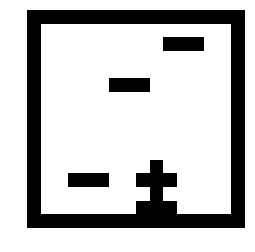

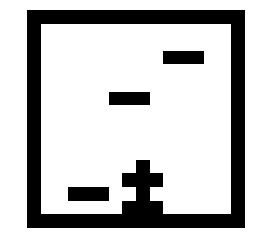

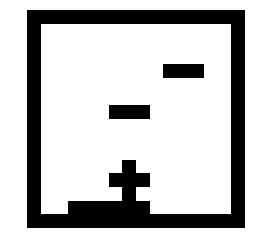

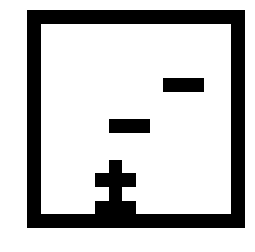

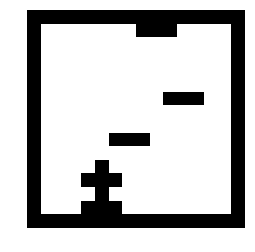

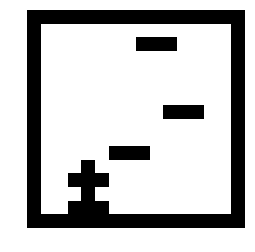

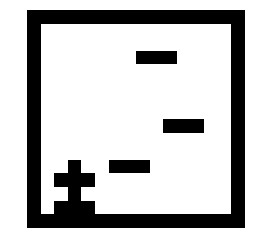

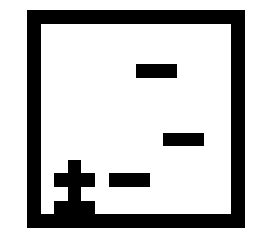

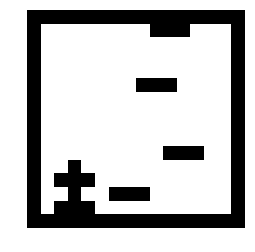

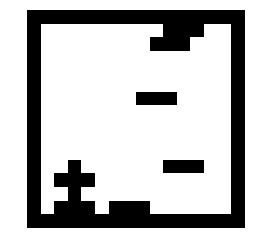

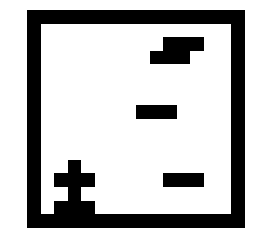

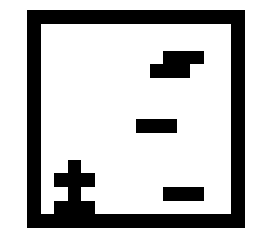

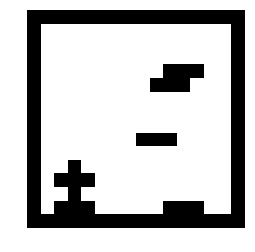

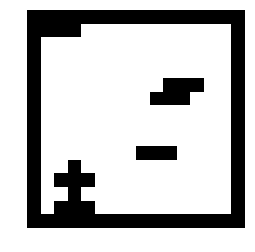

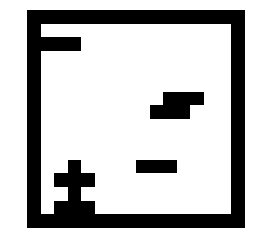

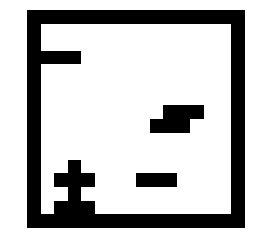

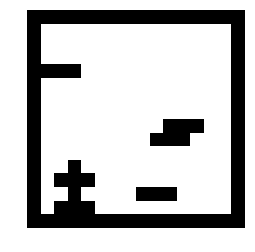

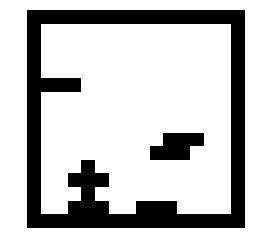

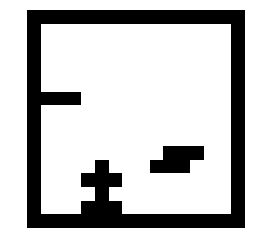

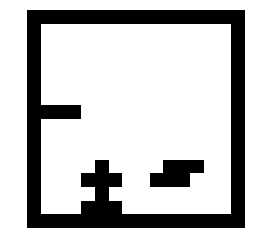

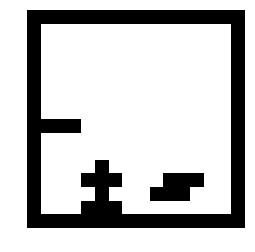

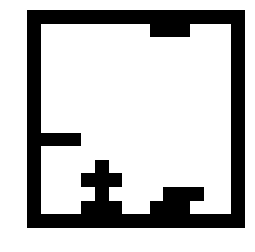

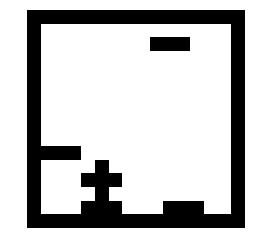

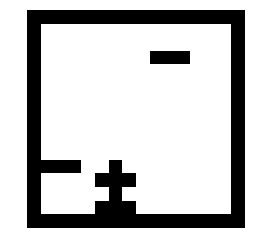

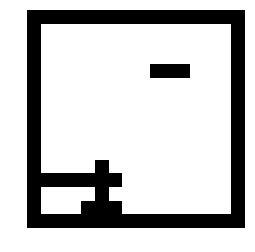

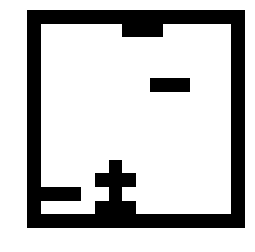

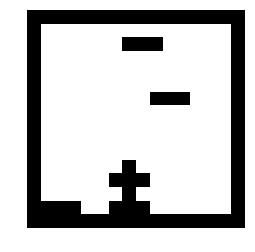

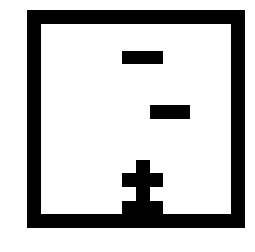

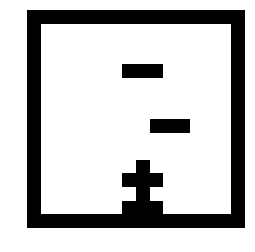

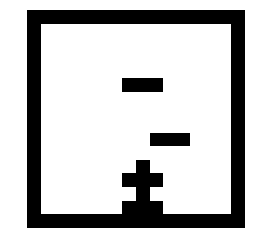

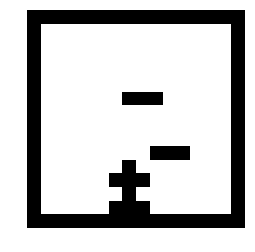

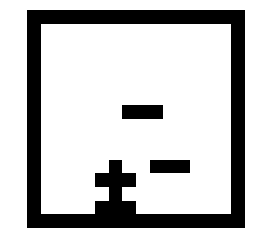

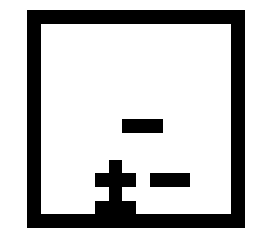

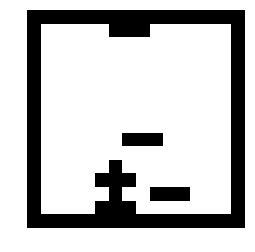

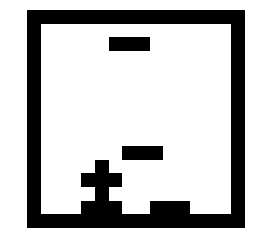

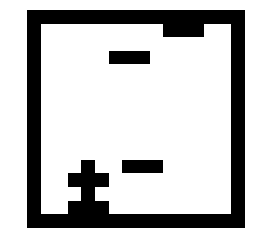

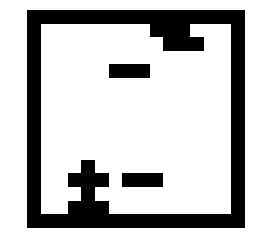

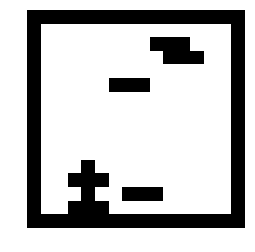

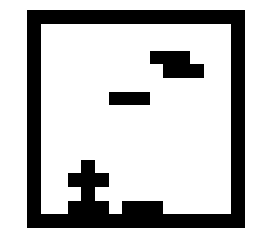

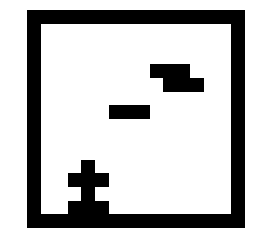

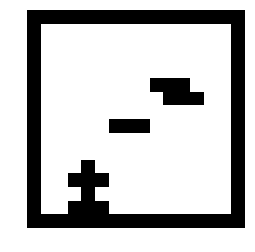

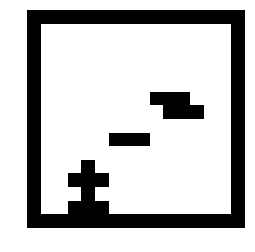

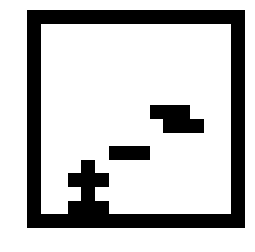

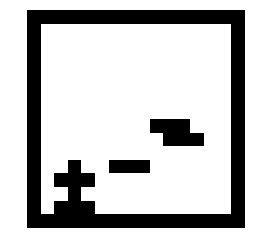

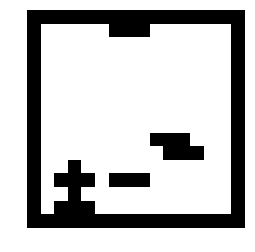

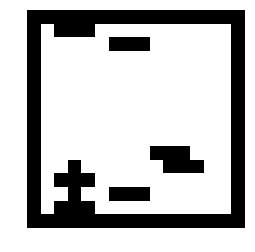

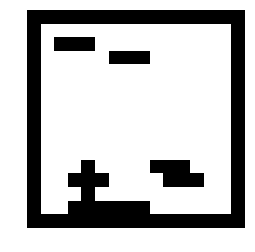

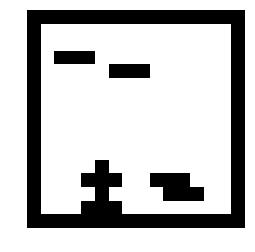

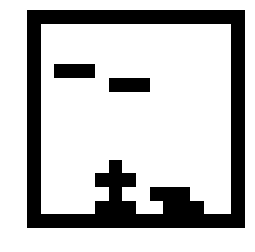

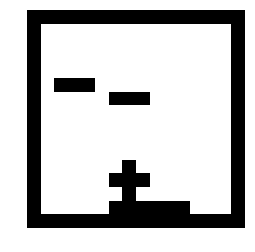

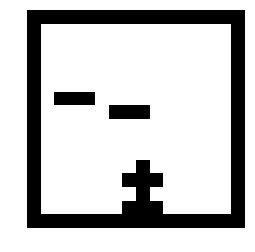

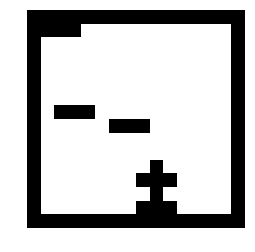

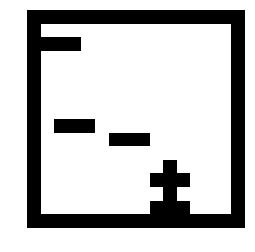

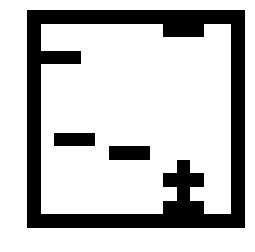

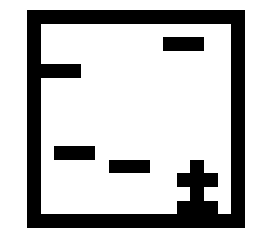

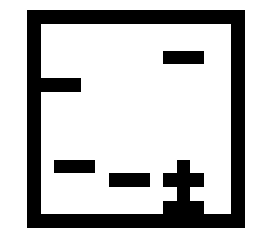

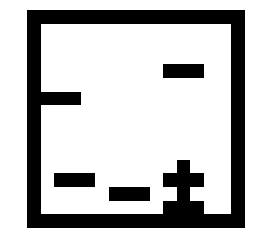

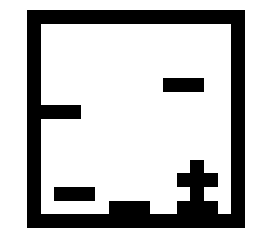

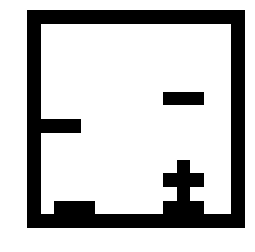

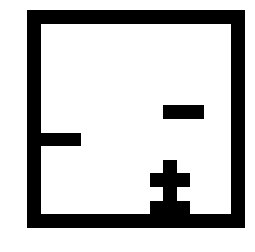

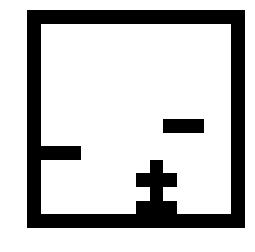

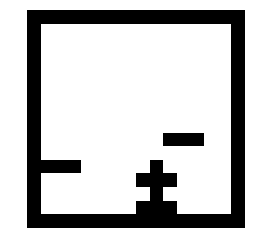

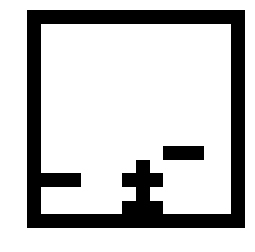

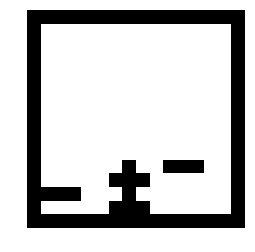

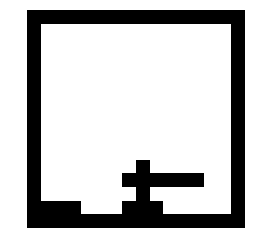

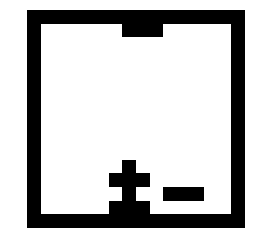

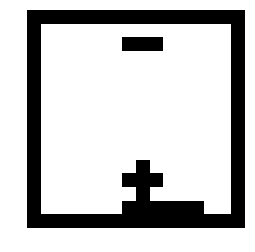

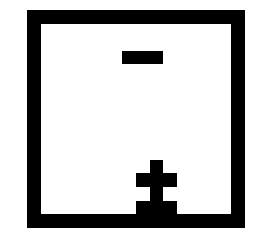

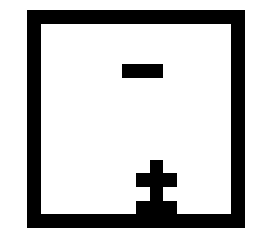

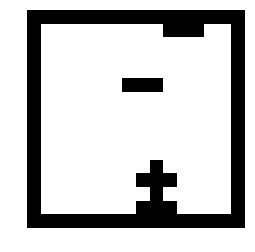

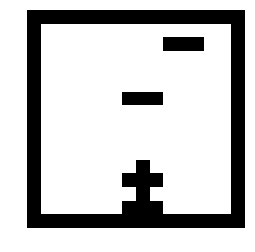

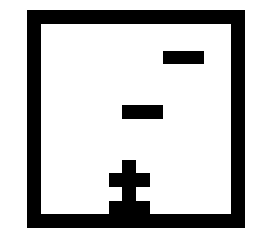

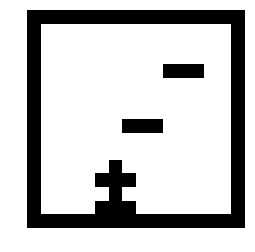

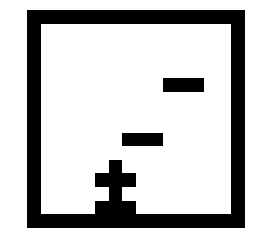

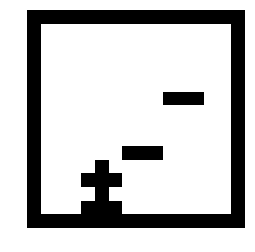

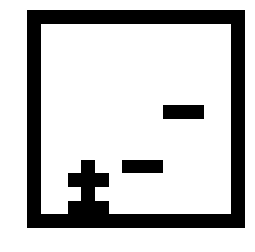

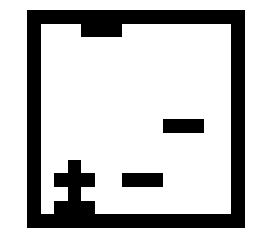

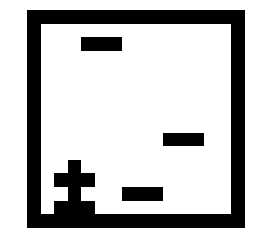

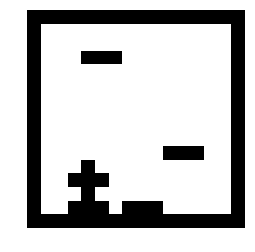

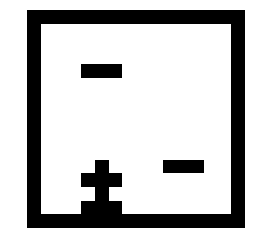

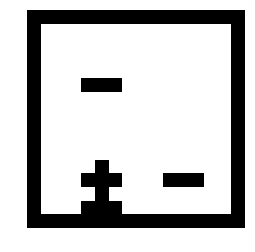

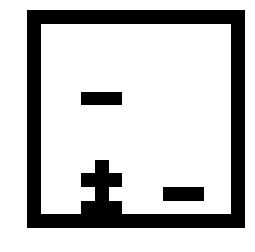

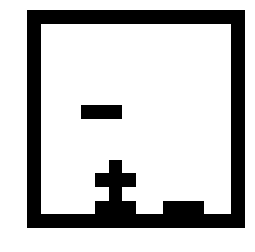

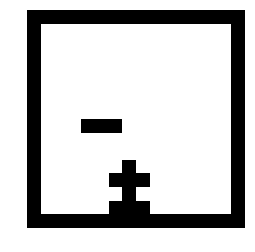

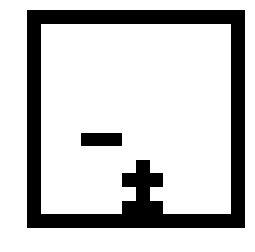

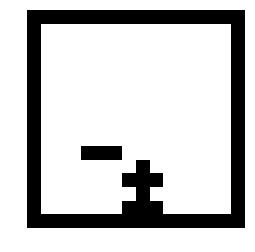

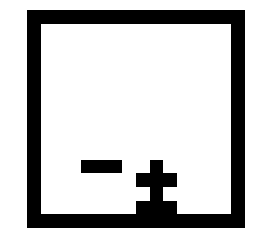

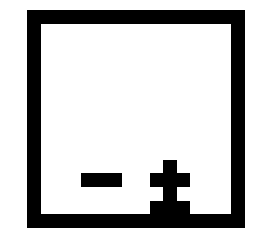

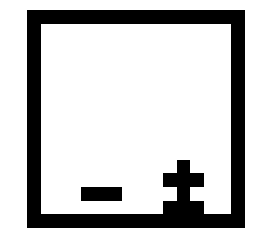

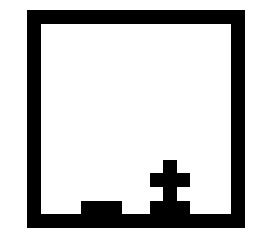

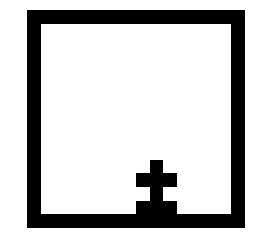

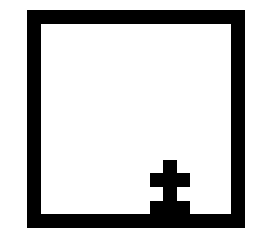

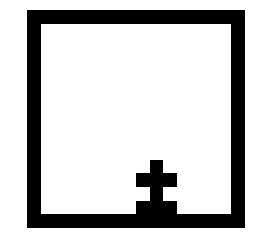

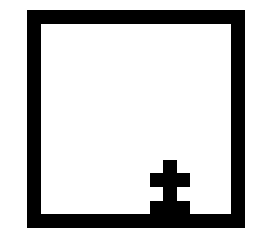

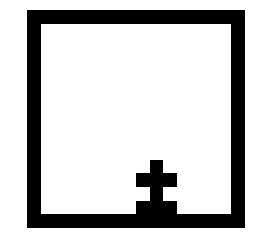

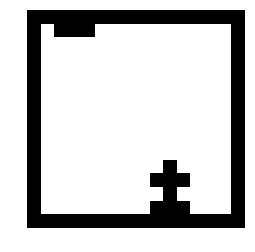

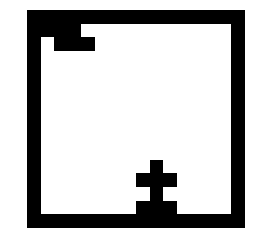

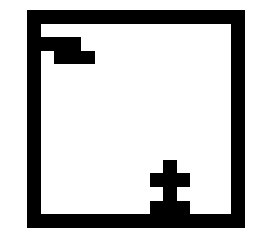

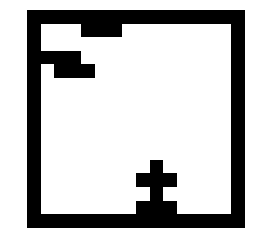

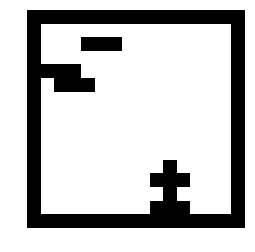

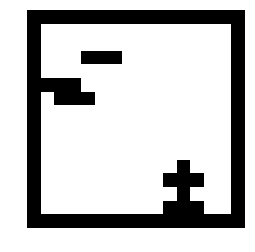

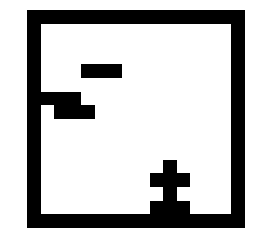

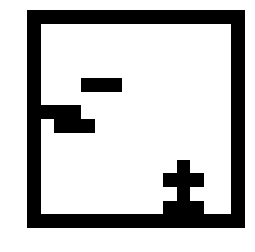

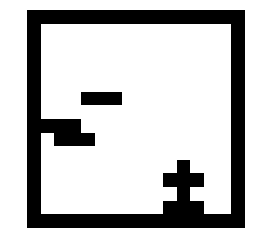

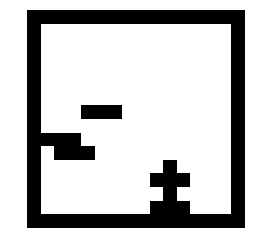

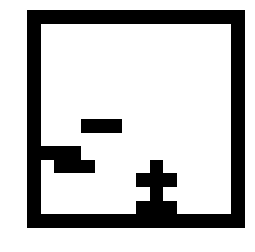

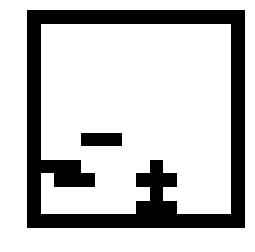

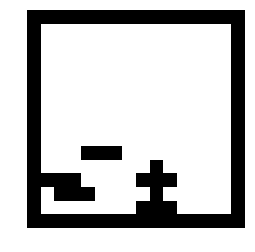

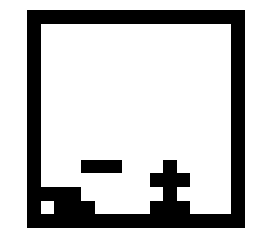

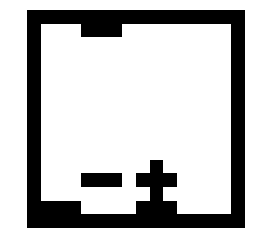

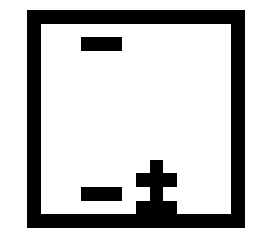

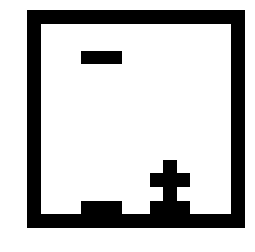

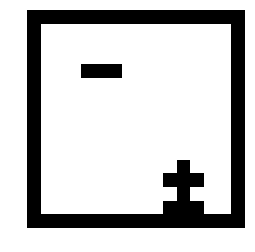

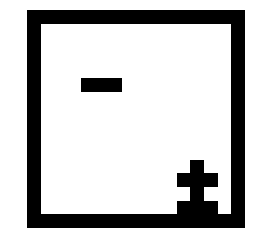

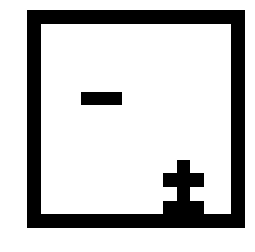

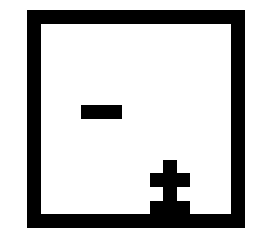

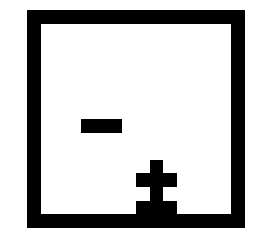

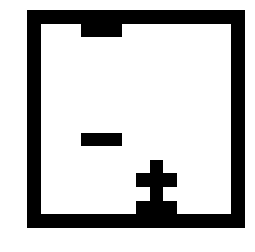

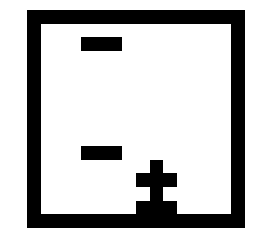

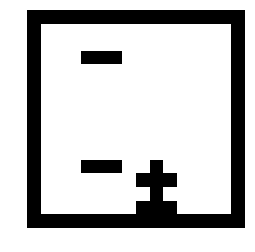

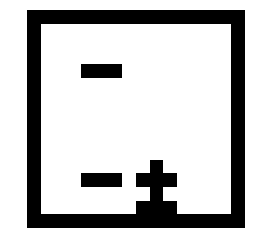

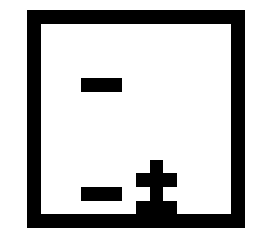

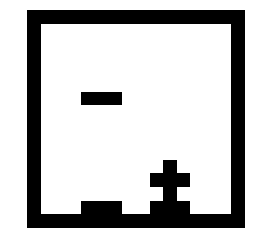

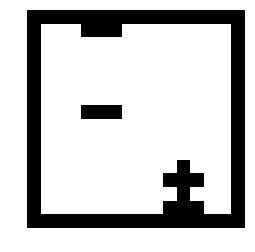

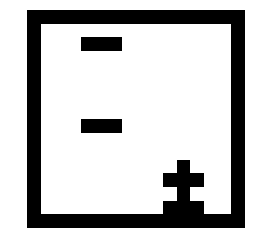

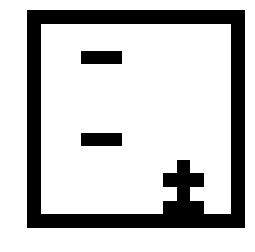

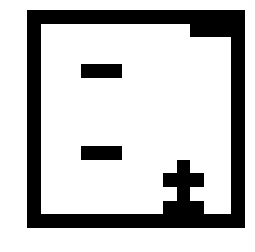

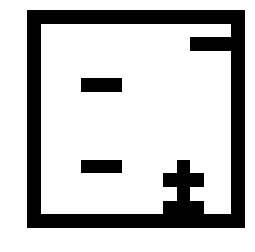

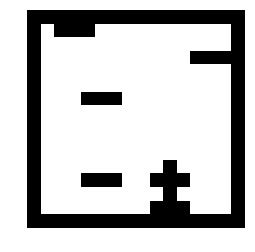

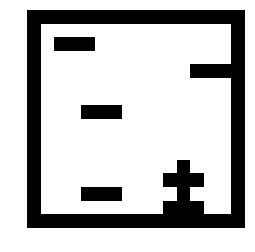

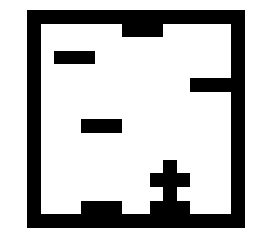

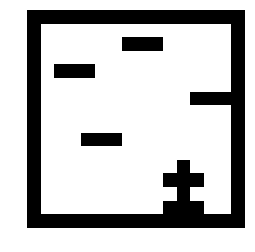

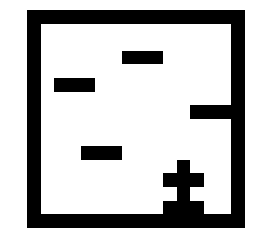

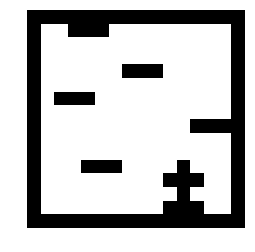

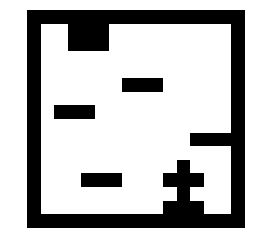

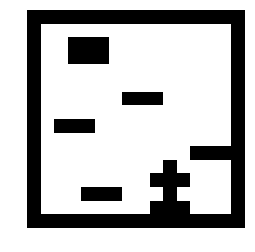

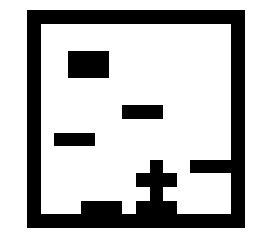

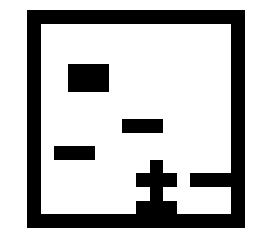

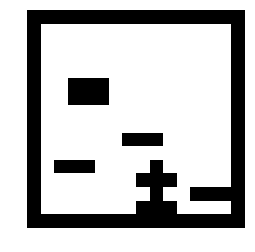

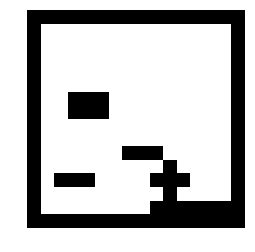

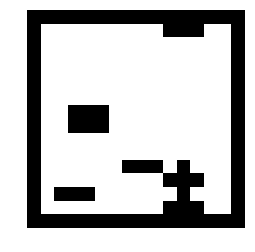

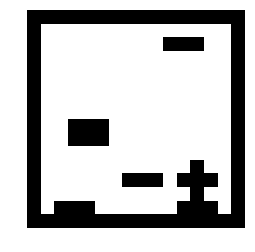

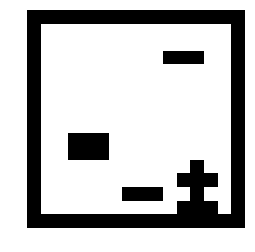

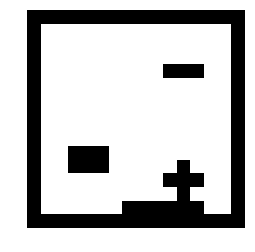

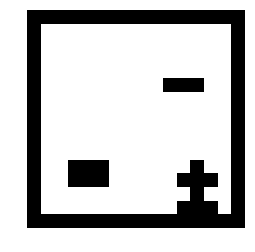

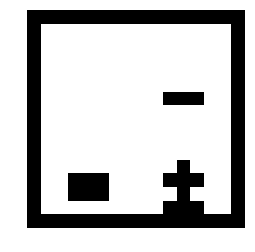

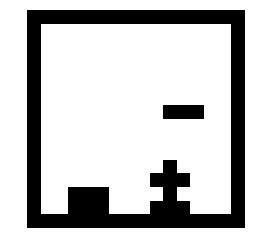

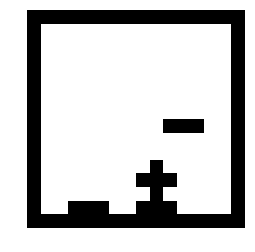

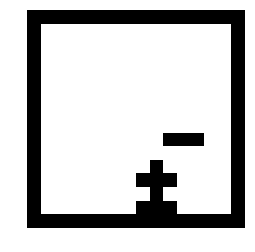

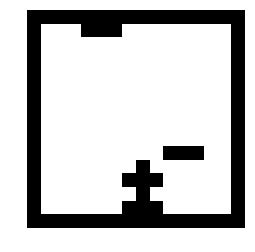

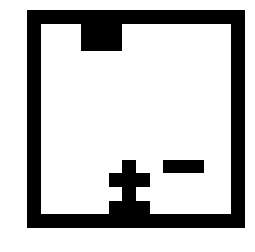

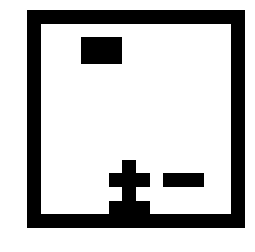

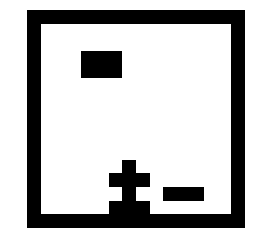

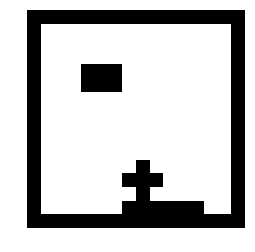

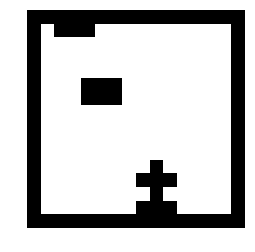

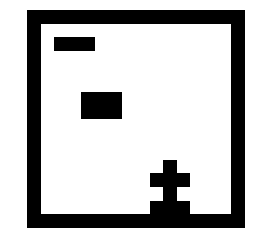

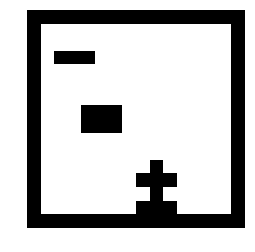

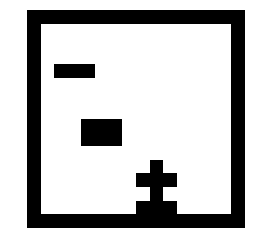

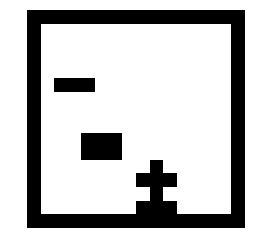

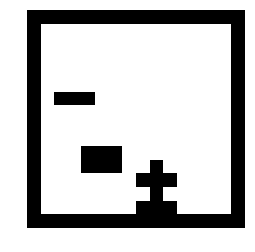

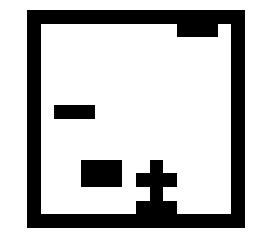

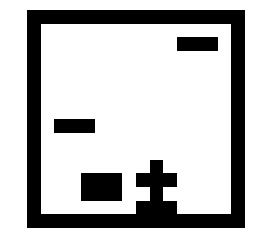

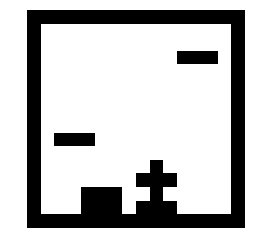

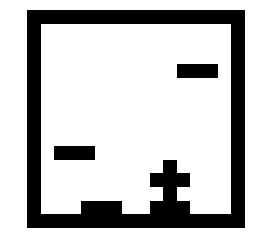

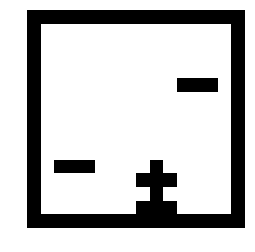

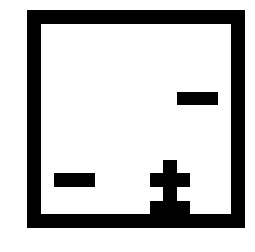

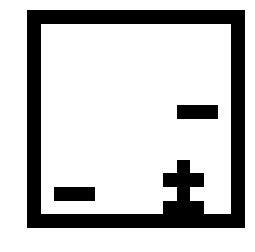

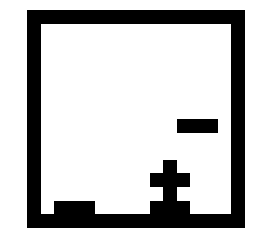

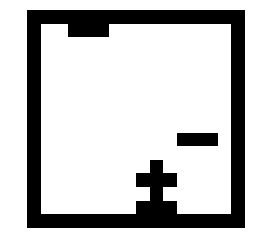

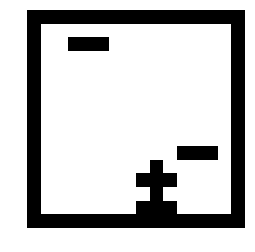

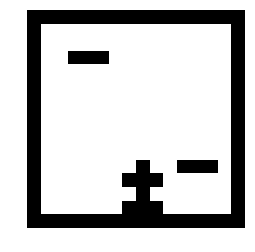

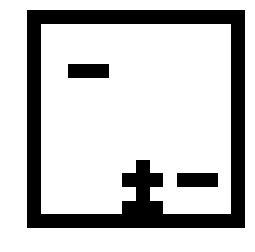

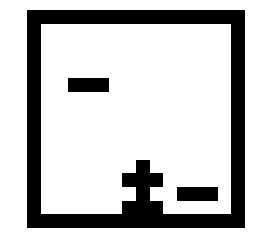

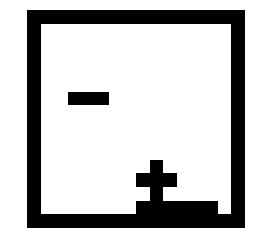

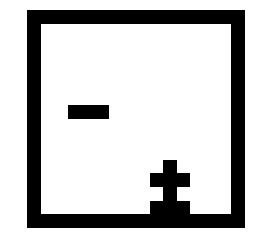

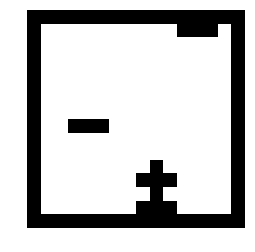

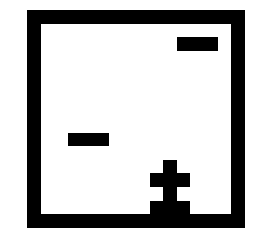

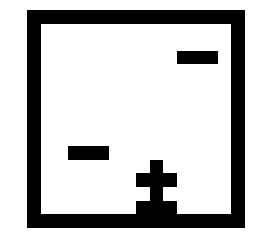

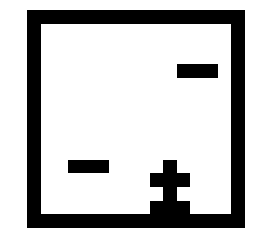

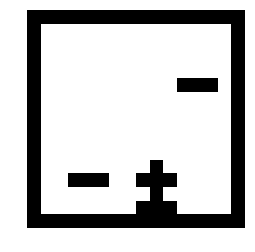

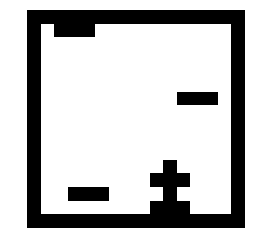

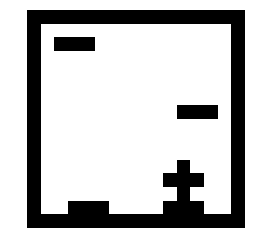

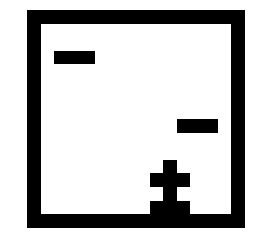

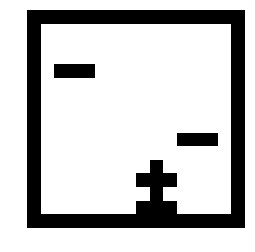

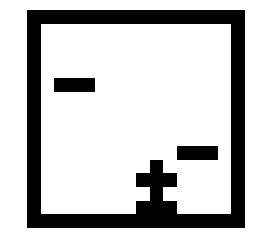

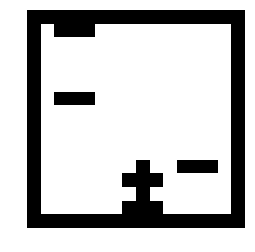

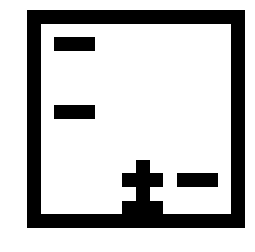

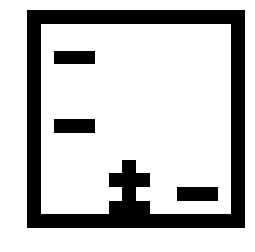

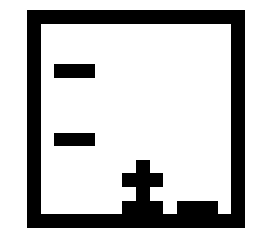

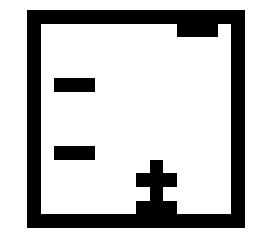

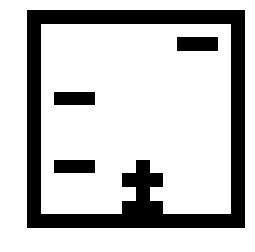

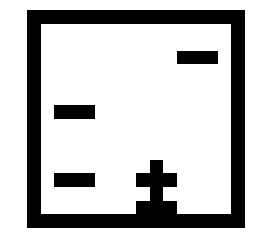

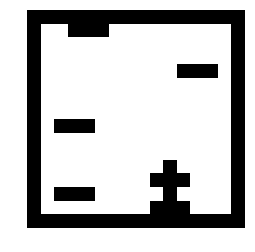

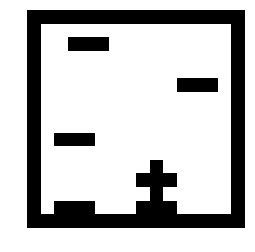

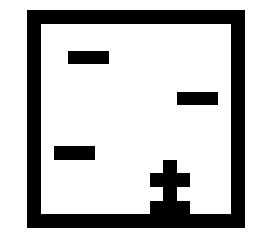

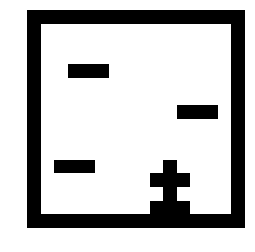

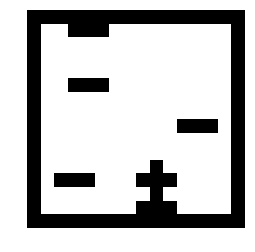

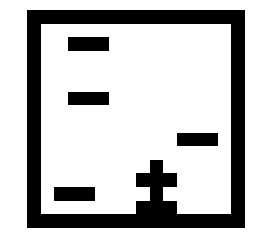

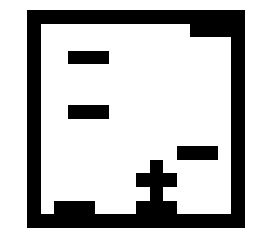

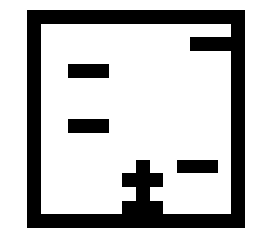

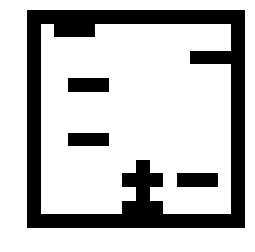

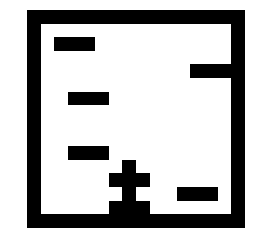

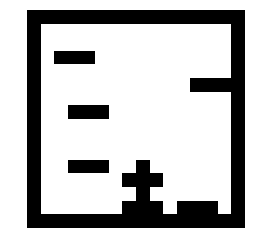

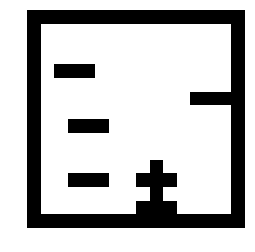

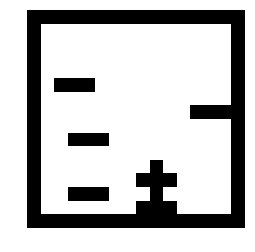

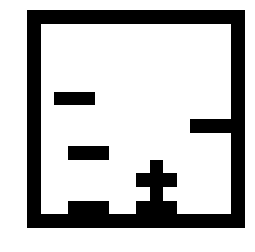

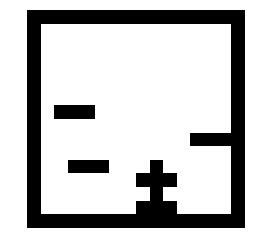

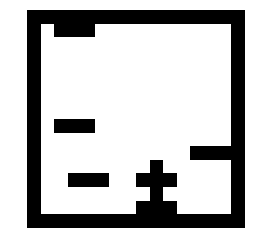

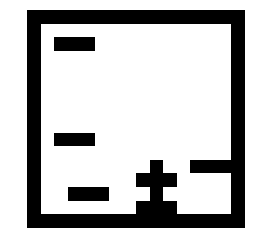

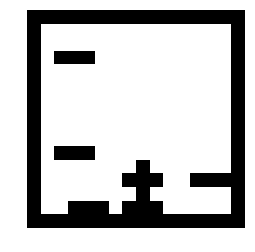

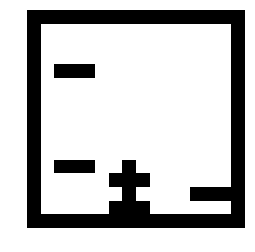

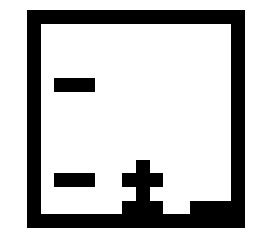

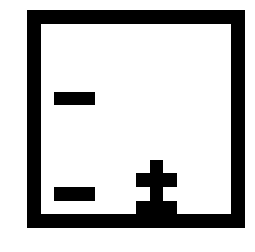

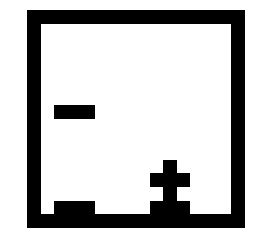

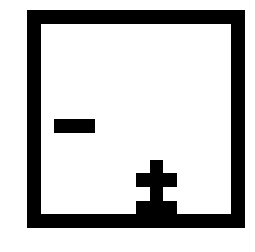

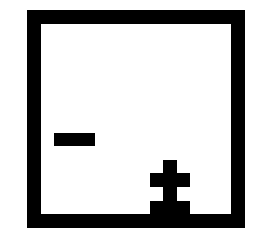

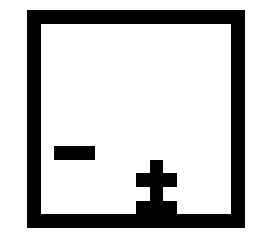

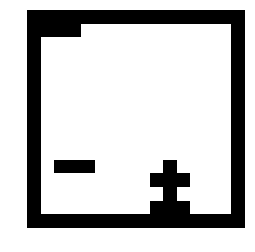

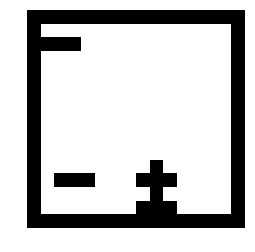

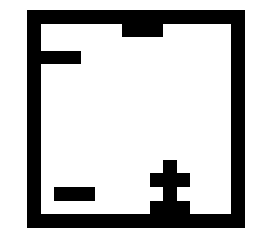

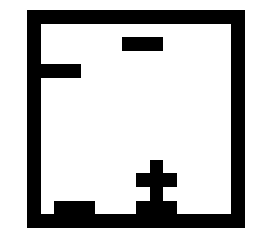

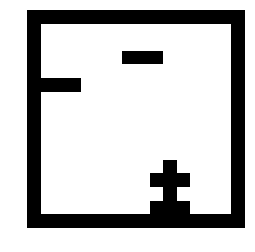

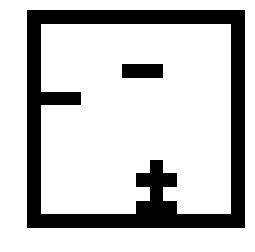

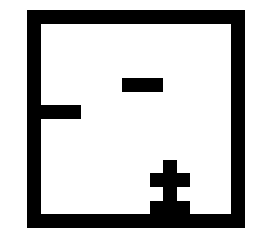

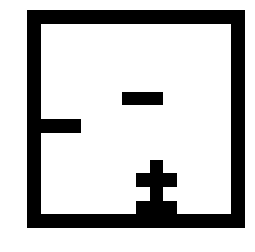

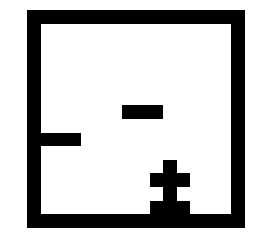

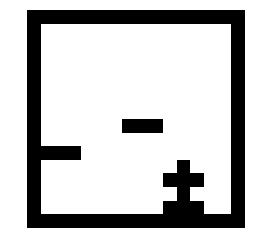

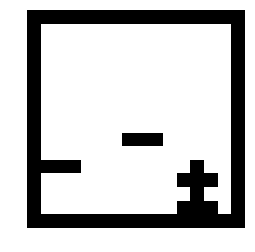

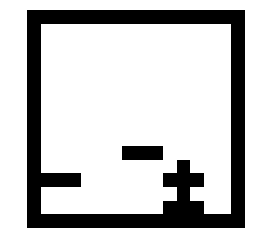

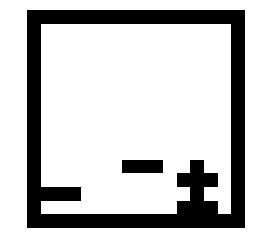

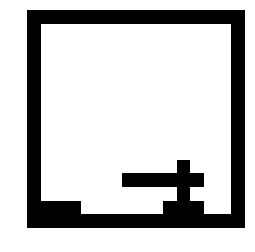

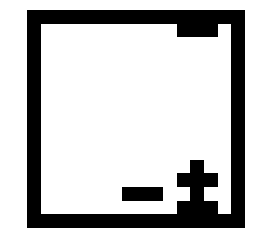

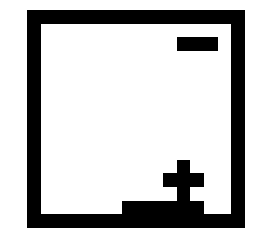

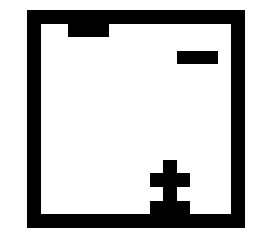

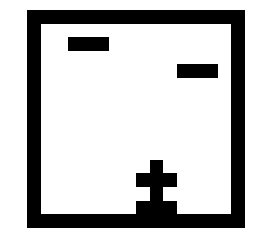

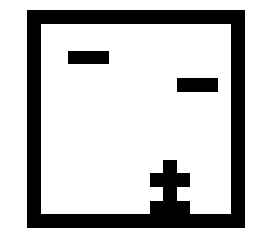

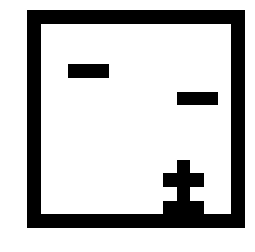

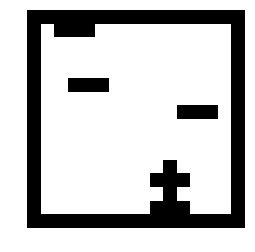

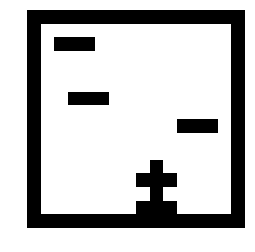

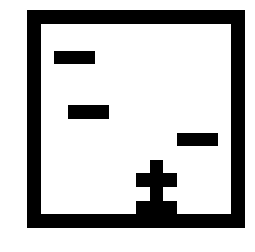

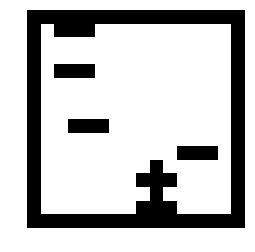

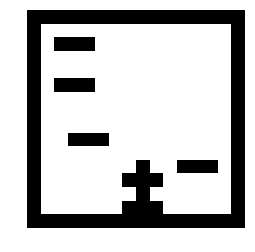

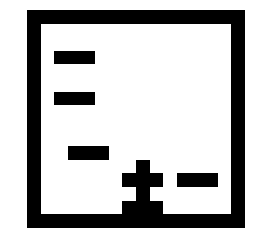

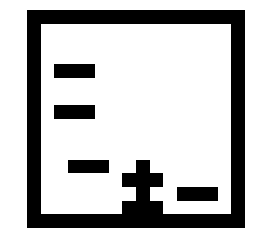

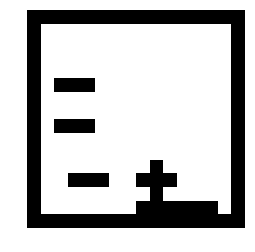

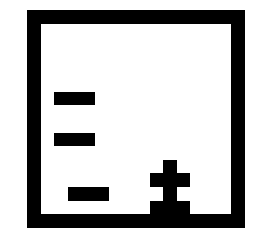

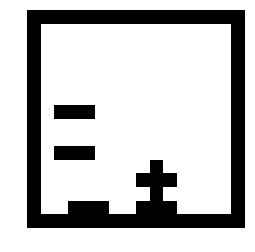

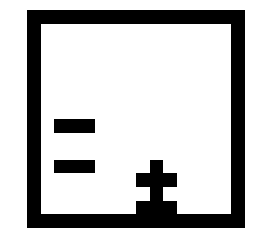

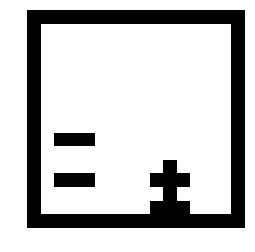

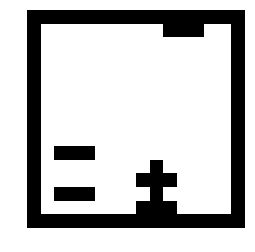

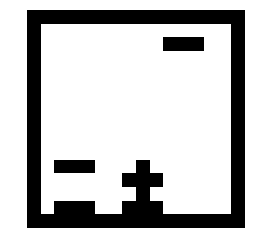

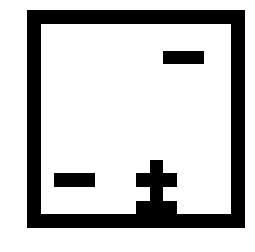

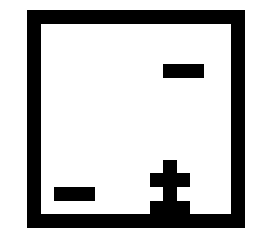

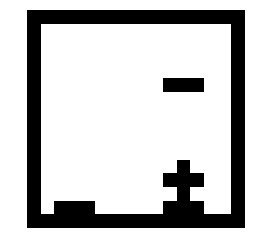

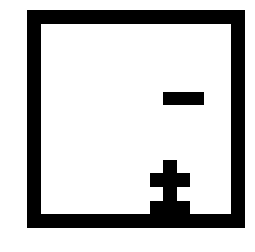

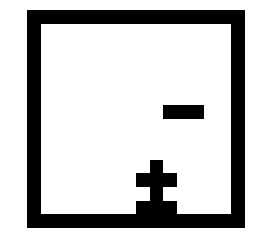

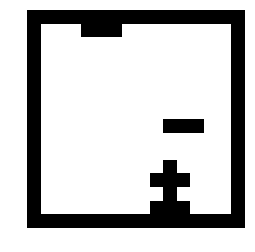

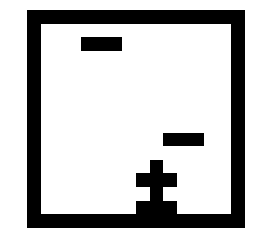

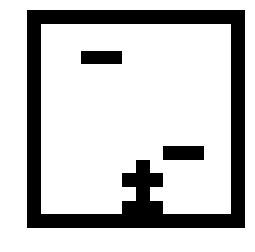

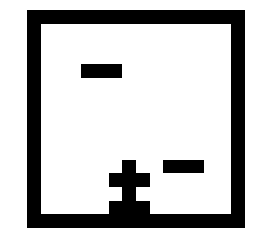

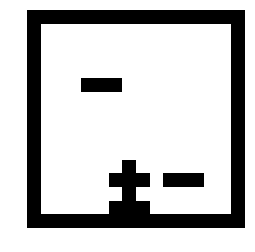

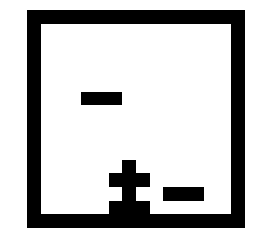

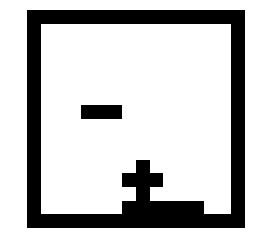

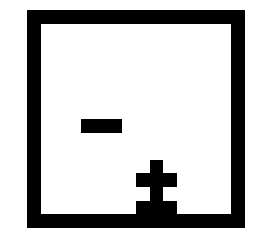

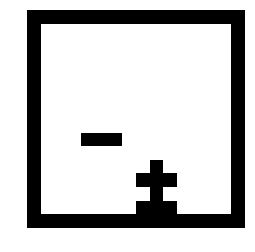

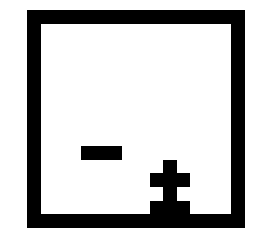

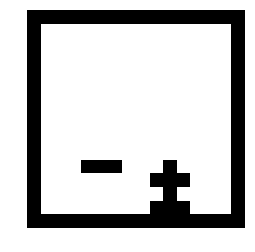

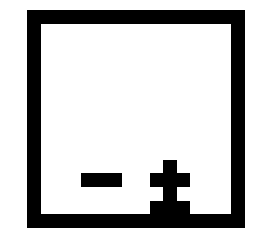

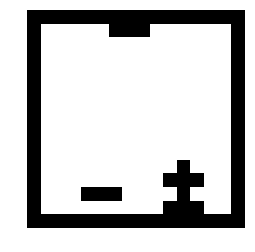

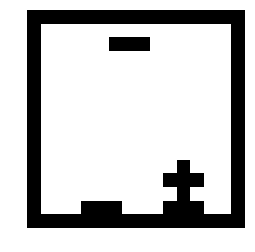

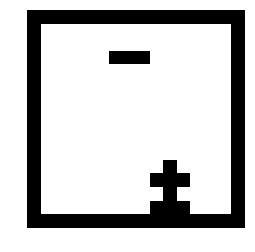

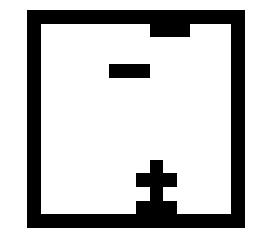

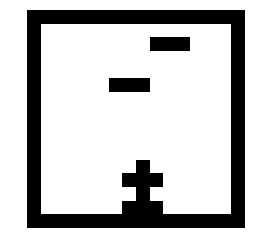

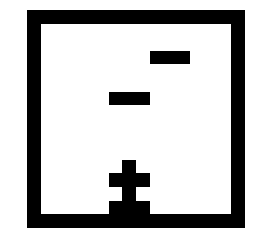

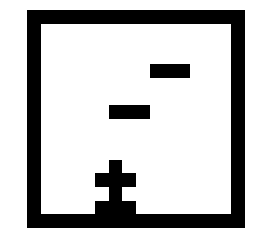

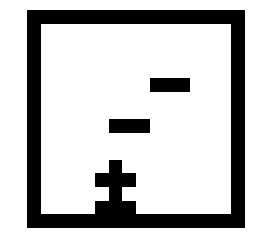

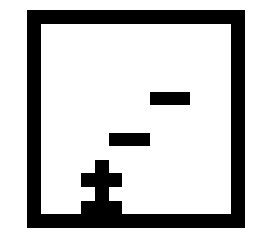

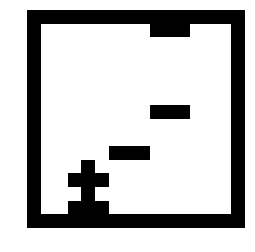

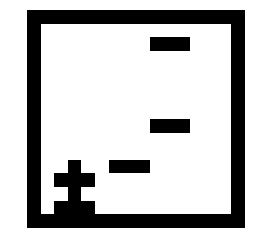

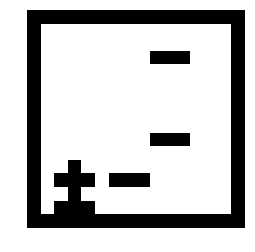

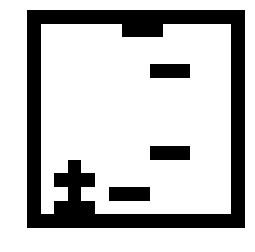

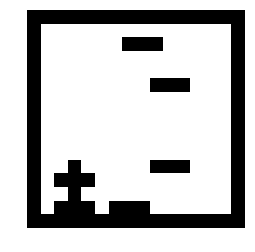

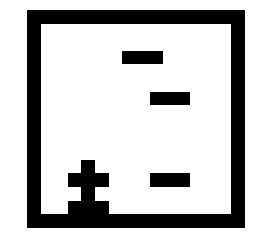

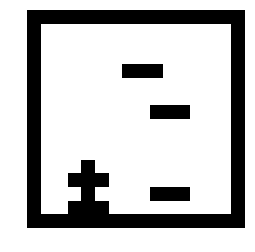

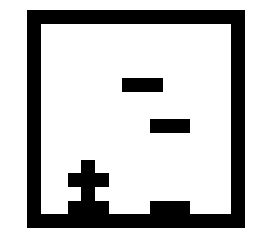

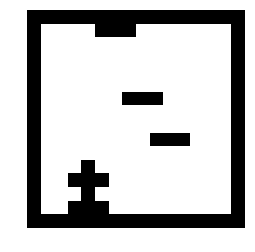

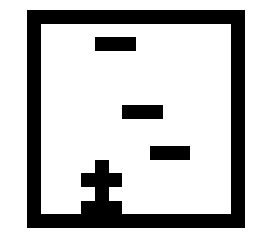

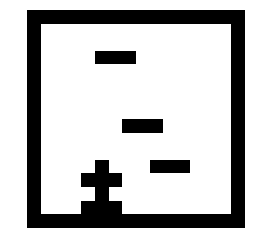

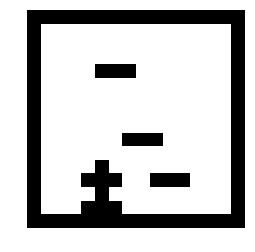

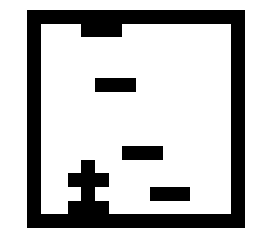

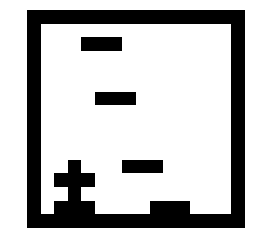

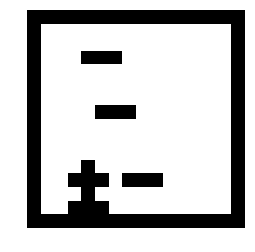

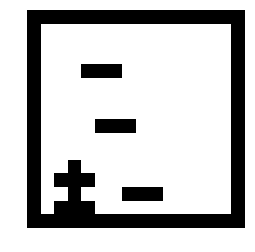

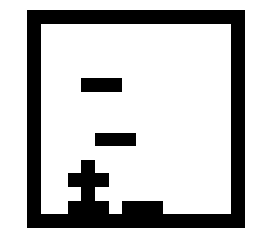

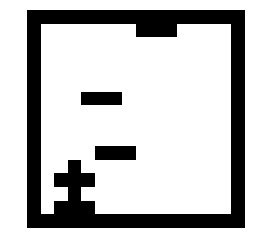

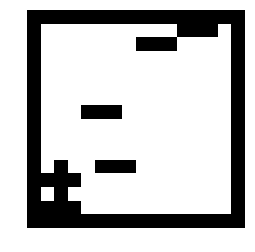

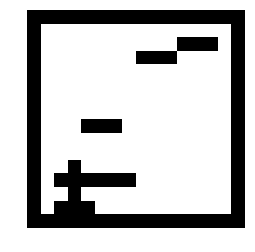

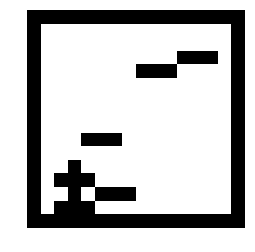

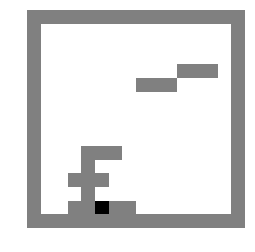

In [518]:
for i in range(len(history_state)):
    plt.imshow(history_state[i,:,:,0])
    plt.axis('off')
    plt.savefig(str(i)+'.png')
    plt.show()